# Spatial Transformer Networks Test

## Setup

In [1503]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from __future__ import print_function, division

import os
import sys

# NOTE: Inferring the project root path like this will not always work
# (e.g. when the notebook resides on a different server to the kernel)
# Set the path directly if necessary.
root_path = os.path.dirname(os.getcwd())

sys.path.append(root_path)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import time
import copy
import glob
import re
import importlib
from PIL import Image

import imednet
from imednet.data.smnist_loader import MatLoader, Mapping
from imednet.trainers.encoder_decoder_trainer import Trainer
from imednet.data.nmnist_loader import NMNIST
from imednet.models.encoder_decoder import CNNEncoderDecoderNet
from imednet.models.encoder_decoder import load_model

plt.ion()   # interactive mode

## Loading the data

Here we use the same data loaders as used in the [PyTorch Spatial Transformer Network Tutorial](https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html) that takes the classic MNIST dataset and uses it to train a standard convolutional network augmented with a spatial transformer network.

In [1468]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root=os.path.join(root_path, 'data/mnist'), train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root=os.path.join(root_path, 'data/mnist'), train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

## Depicting spatial transformer networks

(from the [PyTorch Spatial Transformer Network Tutorial](https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html))

Spatial transformer networks boils down to three main components:

* The localization network is a regular CNN which regresses the transformation parameters. The transformation is never learned explicitly from this dataset, instead the network learns automatically the spatial transformations that enhances the global accuracy.
* The grid generator generates a grid of coordinates in the input image corresponding to each pixel from the output image.
* The sampler uses the parameters of the transformation and applies it to the input image.

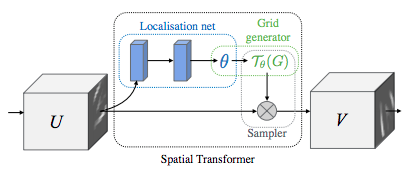

Note: We need the latest version of PyTorch that contains the `affine_grid` and `grid_sample` modules.

In [1469]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = Net().to(device)

## Training the model

(from the [PyTorch Spatial Transformer Network Tutorial](https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html))

Now, let's use the SGD algorithm to train the model. The network is learning the classification task in a supervised way. In the same time the model is learning STN automatically in an end-to-end fashion.

In [1470]:
optimizer = optim.SGD(model.parameters(), lr=0.01)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure STN the performances on MNIST.
#


def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

## Visualizing the STN results

(from the [PyTorch Spatial Transformer Network Tutorial](https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html))

Now, we will inspect the results of our learned visual attention mechanism.

We define a small helper function in order to visualize the transformations while training.

In [1471]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')


for epoch in range(1, 20 + 1):
    train(epoch)
    test()

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.369148
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.222452


Process Process-10:
Process Process-9:
Process Process-12:
Process Process-11:


KeyboardInterrupt: 

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home0/barry.ridge/anaconda3/envs/py3.6_tf1.8.0_cuda9.2/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home0/barry.ridge/anaconda3/envs/py3.6_tf1.8.0_cuda9.2/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home0/barry.ridge/anaconda3/envs/py3.6_tf1.8.0_cuda9.2/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home0/barry.ridge/anaconda3/envs/py3.6_tf1.8.0_cuda9.2/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home0/barry.ridge/anaconda3/envs/py3.6_tf1.8.0_cuda9.2/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home0/barry.ridge/anaconda3/envs/py3.6_tf1.

## Test on s-MNIST Data

In [1473]:
data_path = os.path.join(root_path, 'data/s-mnist/40x40-smnist-seed-42.mat')
images, outputs, scale, original_trj = MatLoader.load_data(data_path)

# digit = 9
# indices = np.asarray(range(0,len(images)))
# test_sample_indices = indices[digit:-1:10]
test_sample_indices = range(1,10)

torch_images = torch.autograd.Variable(torch.from_numpy(images[test_sample_indices, :])).float()
torch_outputs = torch.autograd.Variable(torch.from_numpy(outputs[test_sample_indices, :])).float()

In [1474]:
def visualize_smnist_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = torch_images.reshape(9,1,40,40).to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

In [1475]:
data = torch_images.reshape(9,1,40,40).to(device)

In [1477]:
xs = model.localization(data)
xs = xs.view(-1, 10 * 3 * 3)
theta = model.fc_loc(xs)
theta = theta.view(-1, 2, 3)

theta.shape
# grid = F.affine_grid(theta, data.size())
# x = F.grid_sample(x, grid)

torch.Size([36, 2, 3])

In [1482]:
model_path = os.path.join(root_path, 'models/cnn_encoder_decoder/cfcimednet-40x40-smnist-end-to-end-adam 2018-07-22 17:11:17.144898/')
model = load_model(model_path)
model_stub = 'cfcimednet_etoe_adam'

In [1483]:
trainer = Trainer()

In [1484]:
dmp = trainer.create_dmp(torch_outputs[2], model.scale, 0.01, 25, True)

In [1485]:
dmp.joint()

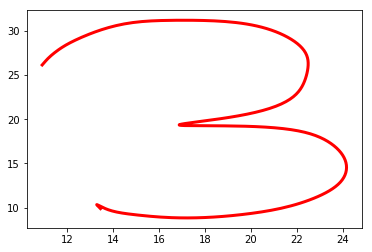

In [1486]:
plt.plot(dmp.Y[:,0], dmp.Y[:,1], '-r', linewidth=3.0)

In [1487]:
# Define rotation matrix
M = np.array([[0.707, -0.707, 0.], [0.707, 0.707, 0.]])
Full_M = np.array([[0.707, -0.707, 0.], [0.707, 0.707, 0.], [0., 0., 1.0]])

In [1488]:
transformed_Y = np.matmul(M, np.hstack([dmp.Y, np.ones([dmp.Y.shape[0],1])]).T).T

In [1489]:
M_I = np.linalg.inv(Full_M)
transformed_Y = np.matmul(Full_M, np.hstack([dmp.Y, np.ones([dmp.Y.shape[0],1])]).T).T
inverted_transformed_Y = np.matmul(M_I, transformed_Y.T).T[:,0:2]
transformed_Y = inverted_transformed_Y

In [1490]:
traj = np.hstack([transformed_Y, dmp.t[:,0:1]])

In [1491]:
dmps = Trainer.create_dmps([traj], dmp.N, 0.01)

/home0/barry.ridge/Research/Projects/ATR/imednet/imednet/utils/dmp_class.py:135: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.w[:,j] = np.linalg.lstsq(np.transpose(A), ft[:,j])[0]


In [1492]:
transformed_dmp = dmps[0]
transformed_dmp.joint()

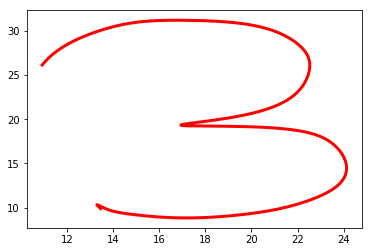

In [1493]:
plt.plot(transformed_dmp.Y[:,0], transformed_dmp.Y[:,1], '-r', linewidth=3.0)

# STIMEDNet

## Define Helper for Displaying Model Predictions

In [1516]:
def show_image_to_motion_prediction(model, trainer, image, output):
    try:
        assert(isinstance(model.image_size, list))
        image_size = model.image_size
    except:
        try:
            assert(isinstance(model.image_size, int))
            image_size = [model.image_size, model.image_size, 1]
        except:
            try:
                image_size = [model.imageSize, model.imageSize, 1]
            except:
                raise
            
    # Prepare input image
    scaled_image = np.array(image).reshape(1, image_size[0]*image_size[1])
    scaled_image = scaled_image / np.max(scaled_image)
    torch_scaled_image = torch.autograd.Variable(torch.from_numpy(scaled_image)).float().cuda()

    # Do full forward propagation, i.e. model.stn(image) -> model.imednet_model()
    torch_predicted_output = model(torch_scaled_image).cpu()
    
    # Set up sub-plotting if the model has an STN module
    try:
        assert(model.stn)
        plt.subplot(121)
    except:
        pass
    
    # Plot original input image    
    plt.imshow((np.reshape(torch_scaled_image.cpu().numpy(), (image_size[0], image_size[1]))), cmap='gray', extent=[0, image_size[0], image_size[1], 0])

    # Try interpreting the predicted output as DMP parameters, integrating the DMP
    # and plotting the resulting trajectory (red).
    try:
        # Generate DMP from predicted output weights
        torch_predicted_output_plus_one = torch.cat((torch.tensor([-1.]), torch_predicted_output[0,:]), 0)
        predicted_output_dmp = trainer.create_dmp(torch_predicted_output_plus_one, model.scale, 0.01, 25, True)
        predicted_output_dmp.joint()
        # Plot the predicted DMP trajectory in red
        plt.plot(predicted_output_dmp.Y[:,0], predicted_output_dmp.Y[:,1], '-r', label='predicted')
    except:
        # Try interpreting the predicted output as an actual trajectory and plotting it directly (red).
        try:
            # Plot predicted trajectory (red)
            plt.plot(torch_predicted_output.cpu().detach().numpy()[0], torch_predicted_output.cpu().detach().numpy()[1], '-r', label='predicted')
        except:
            pass
        
    # Try interpreting the actual output as DMP parameters, integrating the DMP
    # and plotting the resulting trajectory (blue).
    try:
        # Generate DMP from actual output weights
        actual_output_dmp = trainer.create_dmp(torch.from_numpy(output), model.scale, 0.01, 25, True)
        actual_output_dmp.joint()
        # Plot the actual output DMP trajectory in blue
        plt.plot(actual_output_dmp.Y[:,0], actual_output_dmp.Y[:,1], '-b', label='actual')
    except:
        # Try interpreting the predicted output as an actual trajectory and plotting it directly (red).
        try:
            # Plot actual trajectory (blue)
            plt.plot(output[0], output[1], '-b', label='actual')
        except:
            pass

    # Try plotting spatial transformer network (STN) output, if an STN module exists in the model.
    try:
        assert(model.stn)
        assert(model.imednet_model)
        plt.subplot(122)
        
        # Get grid size from model
        try:
            grid_size = model.grid_size
        except:
            raise
        
        # Pass input image to STN module
        try:
            torch_stn_rectified_image, torch_stn_theta = model.stn(torch_scaled_image.view(-1,1,image_size[0],image_size[1]))
        except:
            torch_stn_rectified_image = model.stn(torch_scaled_image.view(-1,1,image_size[0],image_size[1]))

        # Pass STN rectified image to image-to-motion encoder-decoder (IMEDNet)
        torch_imednet_output = model.imednet_model(torch_stn_rectified_image)
        
        # Plot STN rectified output image        
        plt.imshow(torch_stn_rectified_image.reshape(grid_size[0],grid_size[1]).cpu().detach().numpy(), cmap='gray', extent=[0, grid_size[0], grid_size[1], 0])
        
        # Try plotting motion transformer network (MTN) output, if an MTN module exists in the model.
        try:
            assert(model.mtn)
            
            # Integrate IMEDNet DMP output and transform resulting trajectory using theta transform
            x = model.dmp_integrator.apply(torch_imednet_output, model.dmp_p, model.param_grad, model.scale_t)
            x_traj_vectors = x.view(int(x.shape[0]/2), 2, x.shape[1]).transpose(0,1)
            x_traj_vectors_with_ones = torch.cat((x_traj_vectors, torch.ones(1,int(x.shape[0]/2), x.shape[1]).cuda()), 0).cuda()                        
            transformed_x_traj_vectors = torch.einsum('nij,jnm->nim', [torch_stn_theta, x_traj_vectors_with_ones])
            
            # Print theta 
            print('theta: {}'.format(torch_stn_theta))

            # Reshape outputs into vector trajectories
            rectified_output = x_traj_vectors.view(x.shape[0], x.shape[1])
            output = transformed_x_traj_vectors.view(x.shape[0], x.shape[1])
            
            # Plot rectified trajectory
            rectified_traj = rectified_output.detach().cpu().numpy()
            plt.plot(rectified_traj[0], rectified_traj[1], '-', color='tab:purple', label='rectified traj')

            # Plot theta-transformed rectified trajectory 
            # theta_transformed_traj = output.detach().cpu().numpy()
            # plt.plot(theta_transformed_traj[0], theta_transformed_traj[1], '-r', label='transformed traj')
        except:
            try:
                # Generate DMP from predicted output weights
                torch_scaled_image_predicted_output = torch.cat((torch.tensor([-1.]), torch_scaled_image_predicted_output[0,:]), 0)
                scaled_image_predicted_output_dmp = trainer.create_dmp(torch_scaled_image_predicted_output, model.scale, 0.01, 25, True)
                scaled_image_predicted_output_dmp.joint()
                # Display input image + predicted DMP trajectory in red
                fig, _ = trainer.show_dmp(scaled_image, None, scaled_image_predicted_output_dmp, plot=False)

                # Generate DMP from actual output weights
                output_dmp = trainer.create_dmp(torch.from_numpy(output), model.scale, 0.01, 25, True)
                output_dmp.joint()
                # Display the actual output DMP trajectory in green
                plt.plot(output_dmp.Y[:,0], output_dmp.Y[:,1], 'g')
            except:
                pass        

    except Exception as e:
        pass

## Load Models

### Spatial Transformer Image-to-Motion Encoder-Decoder (STIMEDNet) (no motion transformer, no DMP integration) Trained End-to-End with Adam

In [ ]:
model_path = 'models/stimednet/stimednet-40x40-smnist-rotated-images-end-to-end 2018-09-06 15:41:13.276921/'
model = load_model(os.path.join(root_path, model_path))

### Full Spatial Transformer Image-to-Motion Encoder-Decoder (Full STIMEDNet) (with motion transformer, DMP integration) Trained End-to-End with Adam

In [1520]:
# model_path = 'models/stimednet/fullstimednet-40x40-smnist-rotated-images-end-to-end-test 2018-09-12 19:05:29.288979/'
# model_path = 'models/stimednet/fullstimednet-40x40-smnist-rotated-images-end-to-end-test 2018-09-12 19:15:35.427214/'
model_path = 'models/stimednet/fullstimednet-60x60-smnist-rotated-translated-and-scaled-end-to-end-adam 2018-09-13 04:39:25.262185/'
model = load_model(os.path.join(root_path, model_path))

### Convolutional Image-to-Motion Encoder-Decoder with Fully-Connected Encoder Layers (CFCIMEDNet) Trained End-to-End with Adam

In [1505]:
# model_path = 'models/cnn_encoder_decoder/cfcimednet-40x40-smnist-rotated-end-to-end-adam 2018-09-13 13:50:25.373518/'
model_path = 'models/cnn_encoder_decoder/cfcimednet-60x60-smnist-rotated-translated-and-scaled-end-to-end-adam 2018-09-13 13:56:36.338849/'
model = load_model(os.path.join(root_path, model_path))

## Load Datasets

### 40x40 s-MNIST Dataset

In [1498]:
data_path = os.path.join(root_path, 'data/s-mnist/40x40-smnist.mat')
data_stub = '40x40-smnist'
images, outputs, scale, original_trj = MatLoader.load_data(data_path)

### 40x40 Rotated s-MNIST Dataset

In [1499]:
data_path = os.path.join(root_path, 'data/s-mnist/40x40-smnist-rotated.mat')
data_stub = '40x40-smnist-rotated'
# images, outputs, scale, original_trj = MatLoader.load_data(data_path, image_key='trans_imageArray')
images, outputs, scale, or_tr = MatLoader.load_data(data_path,
                                                    image_key='trans_imageArray',
                                                    traj_key='trans_trajArray',
                                                    dmp_params_key='TransDMPParamsArray',
                                                    dmp_traj_key='TransDMPTrajArray',
                                                    load_original_trajectories=True)
original_traj = []
for i in range(0,images.shape[0]):
    c,c1,c2 = zip(*or_tr[i])
    original_traj.append(c)
    original_traj.append(c1)
original_traj = np.asarray(original_traj)
original_traj = original_traj.reshape(-1,2,original_traj.shape[1])

### 60x60 Rotated, Translated and Scaled s-MNIST Dataset

In [1506]:
data_path = os.path.join(root_path, 'data/s-mnist/60x60-smnist-rotated-translated-and-scaled.mat')
data_stub = '60x60-smnist-rotated-translated-and-scaled'
# images, outputs, scale, original_trj = MatLoader.load_data(data_path, image_key='trans_imageArray')
images, outputs, scale, or_tr = MatLoader.load_data(data_path,
                                                    image_key='trans_imageArray',
                                                    traj_key='trans_trajArray',
                                                    dmp_params_key='TransDMPParamsArray',
                                                    dmp_traj_key='TransDMPTrajArray',
                                                    load_original_trajectories=True)
original_traj = []
for i in range(0,images.shape[0]):
    c,c1,c2 = zip(*or_tr[i])
    original_traj.append(c)
    original_traj.append(c1)
original_traj = np.asarray(original_traj)
original_traj = original_traj.reshape(-1,2,original_traj.shape[1])

## Plot Model Predictions

### Define Helper Function for Sampling Specific Digit

In [1507]:
def sample_indices_ending_with(array, ending, n):
    """Sample n indices from array ending with specified digit."""
    indices = []
    count = 0
    while count < n:
        i = np.random.randint(array.shape[0])
        if (i % 10) == ending:
            indices.append(i)
            count += 1
    return indices

### Plot Predictions for Multiple Digit Samples

theta: tensor([[[ 0.3898,  0.4461,  0.1360],
         [ 0.7301, -0.2066,  0.0809]]],
       device='cuda:0', grad_fn=<ViewBackward>)


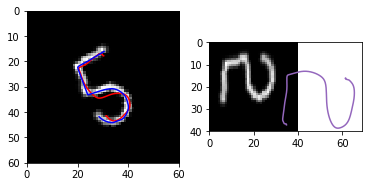

theta: tensor([[[ 0.3926,  0.3951,  0.0108],
         [ 0.6001, -0.1590,  0.1315]]],
       device='cuda:0', grad_fn=<ViewBackward>)


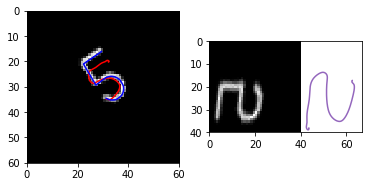

theta: tensor([[[ 0.4893,  0.5022,  0.0130],
         [ 0.5270, -0.1783,  0.1103]]],
       device='cuda:0', grad_fn=<ViewBackward>)


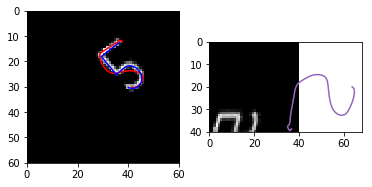

theta: tensor([[[ 0.2393,  0.5500,  0.0149],
         [ 0.7636, -0.1436,  0.1537]]],
       device='cuda:0', grad_fn=<ViewBackward>)


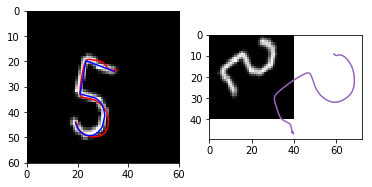

theta: tensor([[[ 0.0960,  0.5114, -0.1208],
         [ 0.6360, -0.0278,  0.1886]]],
       device='cuda:0', grad_fn=<ViewBackward>)


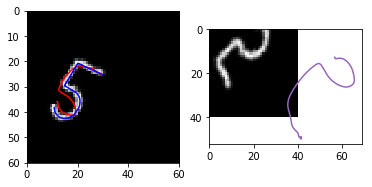

theta: tensor([[[ 0.3307,  0.4351,  0.0348],
         [ 0.5724, -0.2171,  0.0059]]],
       device='cuda:0', grad_fn=<ViewBackward>)


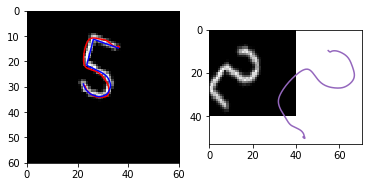

theta: tensor([[[ 0.3043,  0.4636,  0.0501],
         [ 0.6195, -0.0360,  0.1858]]],
       device='cuda:0', grad_fn=<ViewBackward>)


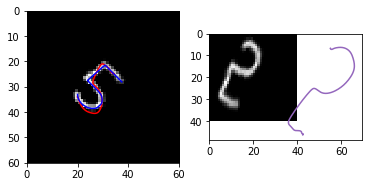

theta: tensor([[[ 0.1304,  0.4926, -0.0786],
         [ 0.6100,  0.0299,  0.1669]]],
       device='cuda:0', grad_fn=<ViewBackward>)


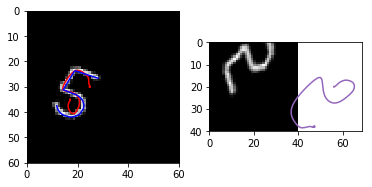

theta: tensor([[[ 0.3276,  0.4051,  0.0709],
         [ 0.6613, -0.0650,  0.0877]]],
       device='cuda:0', grad_fn=<ViewBackward>)


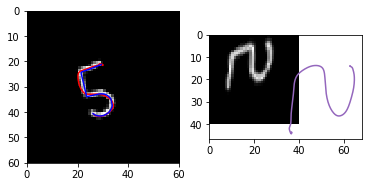

theta: tensor([[[ 0.1683,  0.5131, -0.0765],
         [ 0.7253, -0.0024,  0.1801]]],
       device='cuda:0', grad_fn=<ViewBackward>)


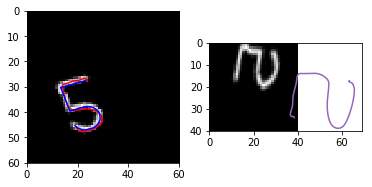

theta: tensor([[[ 0.2753,  0.2680, -0.0063],
         [ 0.5668, -0.1581,  0.0759]]],
       device='cuda:0', grad_fn=<ViewBackward>)


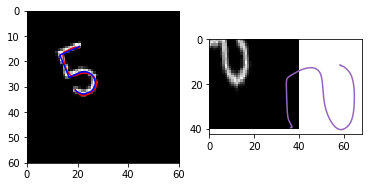

theta: tensor([[[ 0.3976,  0.5081,  0.1619],
         [ 0.8017, -0.2814,  0.1037]]],
       device='cuda:0', grad_fn=<ViewBackward>)


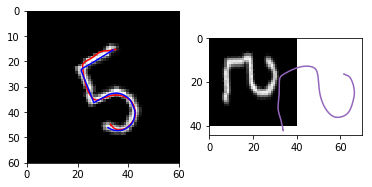

theta: tensor([[[ 0.3156,  0.3297,  0.0237],
         [ 0.6165, -0.1391,  0.1310]]],
       device='cuda:0', grad_fn=<ViewBackward>)


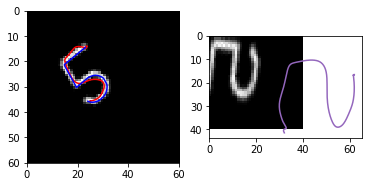

theta: tensor([[[ 0.2940,  0.4892,  0.0828],
         [ 0.8043, -0.1168,  0.1711]]],
       device='cuda:0', grad_fn=<ViewBackward>)


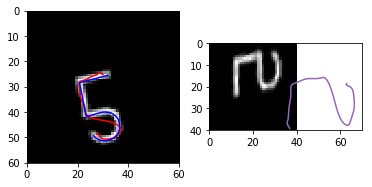

theta: tensor([[[ 0.4494,  0.5315,  0.1593],
         [ 0.7637, -0.1033,  0.2464]]],
       device='cuda:0', grad_fn=<ViewBackward>)


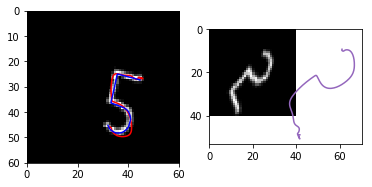

theta: tensor([[[ 0.2026,  0.3612, -0.0059],
         [ 0.5850, -0.1996,  0.0556]]],
       device='cuda:0', grad_fn=<ViewBackward>)


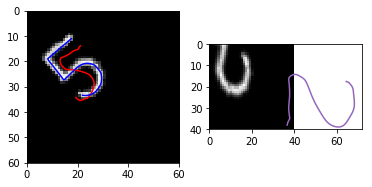

theta: tensor([[[ 0.3216,  0.3936,  0.0963],
         [ 0.6423, -0.0770,  0.1245]]],
       device='cuda:0', grad_fn=<ViewBackward>)


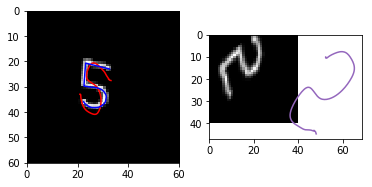

theta: tensor([[[ 0.3148,  0.4790,  0.1005],
         [ 0.7313, -0.0449,  0.1861]]],
       device='cuda:0', grad_fn=<ViewBackward>)


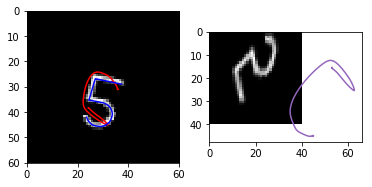

theta: tensor([[[ 0.4734,  0.4839,  0.0519],
         [ 0.6124, -0.1383,  0.1990]]],
       device='cuda:0', grad_fn=<ViewBackward>)


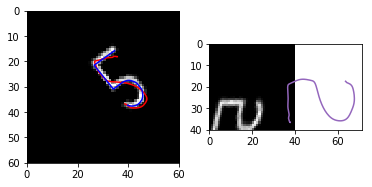

theta: tensor([[[ 0.4361,  0.5006,  0.0977],
         [ 0.5968, -0.0721,  0.1070]]],
       device='cuda:0', grad_fn=<ViewBackward>)


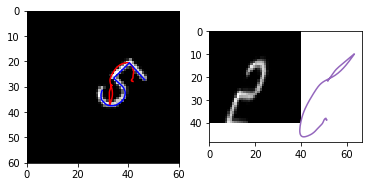

In [1521]:
# Plot model predictions for multiple samples of a particular digit
i_samples = sample_indices_ending_with(images, 5, 20)
for i_sample in i_samples:
    plt.figure()
    sample_image = images[i_sample,:].reshape(images.shape[1],images.shape[2])
    try:
        assert(model.dmp_integrator)
        sample_output = original_traj[i_sample]
    except:
        sample_output = outputs[i_sample,:]
    show_image_to_motion_prediction(model, trainer, sample_image, sample_output)
    plt.show()